##### Imports and initialization

In [1]:
%matplotlib inline

import os,sys
#path = os.path.realpath(os.path.join(os.getcwd(), ".."))
path = "/home/zantyr/Denoising"
sys.path.append(path)
os.chdir(path)

import matplotlib.pyplot as plt
import numpy as np
import pickle
import scipy.io.wavfile as sio
import tempfile

from IPython.display import Image, Audio, display

import keras
from keras.utils.vis_utils import plot_model
from keras.layers         import Dropout, Input, Conv1D, Conv2D, AveragePooling2D, Flatten, Dense, Deconv2D, UpSampling2D, concatenate, BatchNormalization, Lambda, LeakyReLU, TimeDistributed, Reshape, LSTM, GaussianNoise
from keras.models         import Model
from keras.datasets.mnist import load_data
from keras.utils          import to_categorical
from keras.initializers   import Orthogonal
from keras.regularizers   import L1L2, l2
from keras.callbacks      import Callback
import keras.backend as K
import tensorflow as tf

import loaders
from loaders.transform import AddGaussianNoise, Windowing, GSMize, MixReverb, MixNoise, ConstantQTransform, Transcript, LengthOfWindow, Length, Lengthen, Null, DivisiblePad
from loaders.dataset import Dataset, enable_multiprocessing, disable_multiprocessing
from loaders.feature import NormalizedLogPowerRFFT, Trim
from loaders.experiment import SingleExperiment
from loaders.measures import MSE
from loaders.schedule import Schedule
from loaders.estimator import DefaultVisualizeTransform, Estimator
from loaders.extras import LossHistory, set_device, delog_griffin_lim, get_stft
from loaders.custom import identity_loss
set_device()               # switches to CPU if GPU busy
enable_multiprocessing()   # for faster preprocessing of data (multicore)

Using TensorFlow backend.


Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Switching to CPU only as GPU is busy or unavailable


Process ForkPoolWorker-6:
Process ForkPoolWorker-3:
Process ForkPoolWorker-9:
Process ForkPoolWorker-4:
Process ForkPoolWorker-5:
Process ForkPoolWorker-7:
Process ForkPoolWorker-8:
Process ForkPoolWorker-2:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/site-packages/multiprocess/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/site-packages/multiprocess/process.py", line 249, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python3.6/site-packages/multiprocess/process.py", line 249, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python3.6/site-packages/multiprocess/process.py", line 249, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python3.6/site-packages/multiprocess/process.py", line 93, in run
    s

##### Model definition

In [2]:
model_callbacks = []

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_lf (InputLayer)        (None, None, 129)         0         
_________________________________________________________________
lambda_1 (Lambda)            (None, None, 129, 1)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, 129, 16)     160       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, None, 129, 16)     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, 129, 20)     1620      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, None, 129, 20)     0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, None, 129, 24)     4344      
__________

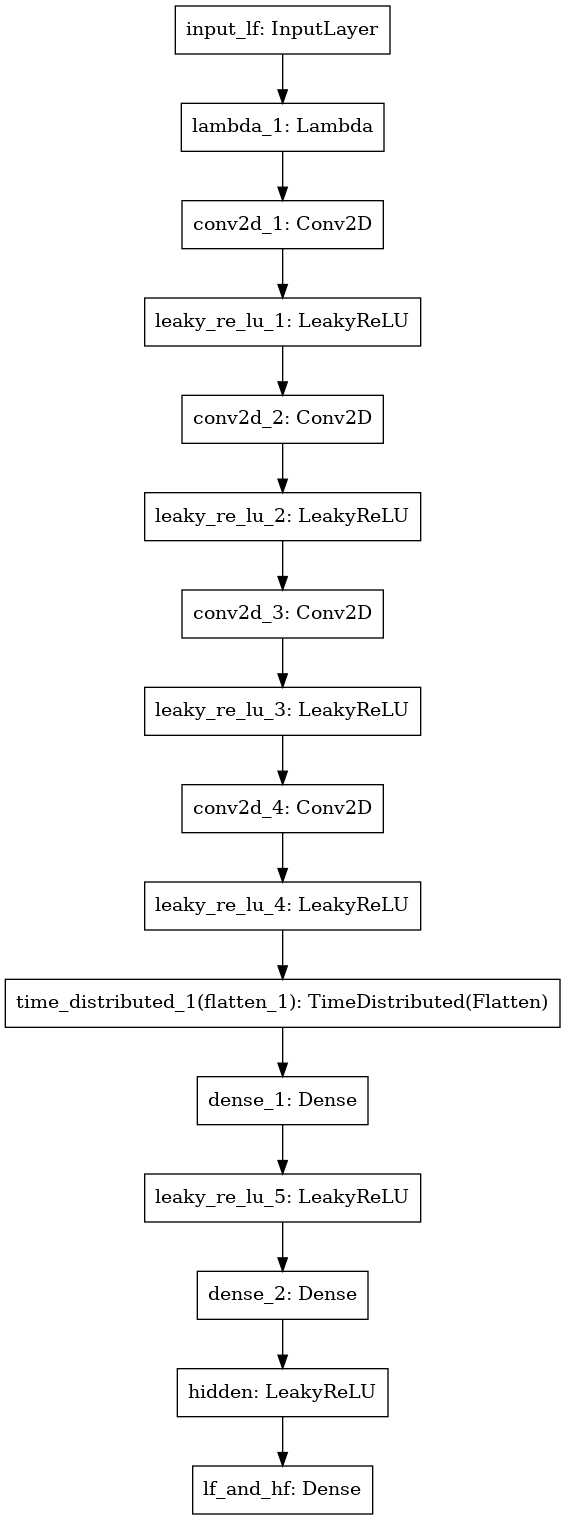

In [3]:
# additions to 2-AMR models:

def mk_model():
    input_lower = Input((None, 129), name="input_lf")
    layer = Lambda(lambda x: K.expand_dims(x))(input_lower)
    layer = LeakyReLU(0.01)(Conv2D(16, kernel_size=(9,1), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.01)(Conv2D(20, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.01)(Conv2D(24, kernel_size=(9,1), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.01)(Conv2D(28, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = TimeDistributed(Flatten())(layer)
    layer = LeakyReLU(0.01)(Dense(1024)(layer))
    hidden = layer = LeakyReLU(0.01, name='hidden')(Dense(512)(layer))
    lf_and_hf = Dense(257, name="lf_and_hf")(layer)
    mdl = Model(input_lower, lf_and_hf)
    mdl.summary()
    mdl.compile('adam', 'mse')
    return mdl

temp = tempfile.mktemp() + ".png"
mdl = mk_model()
model_callbacks.append(mk_model)
plot_model(mdl, to_file=temp)
Image(filename=temp)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_lf (InputLayer)        (None, None, 129)         0         
_________________________________________________________________
lambda_2 (Lambda)            (None, None, 129, 1)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, None, 129, 16)     160       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, None, 129, 20)     1620      
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, None, 129, 20)     0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, None, 129, 24)     4344      
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, None, 129, 24)     0         
__________

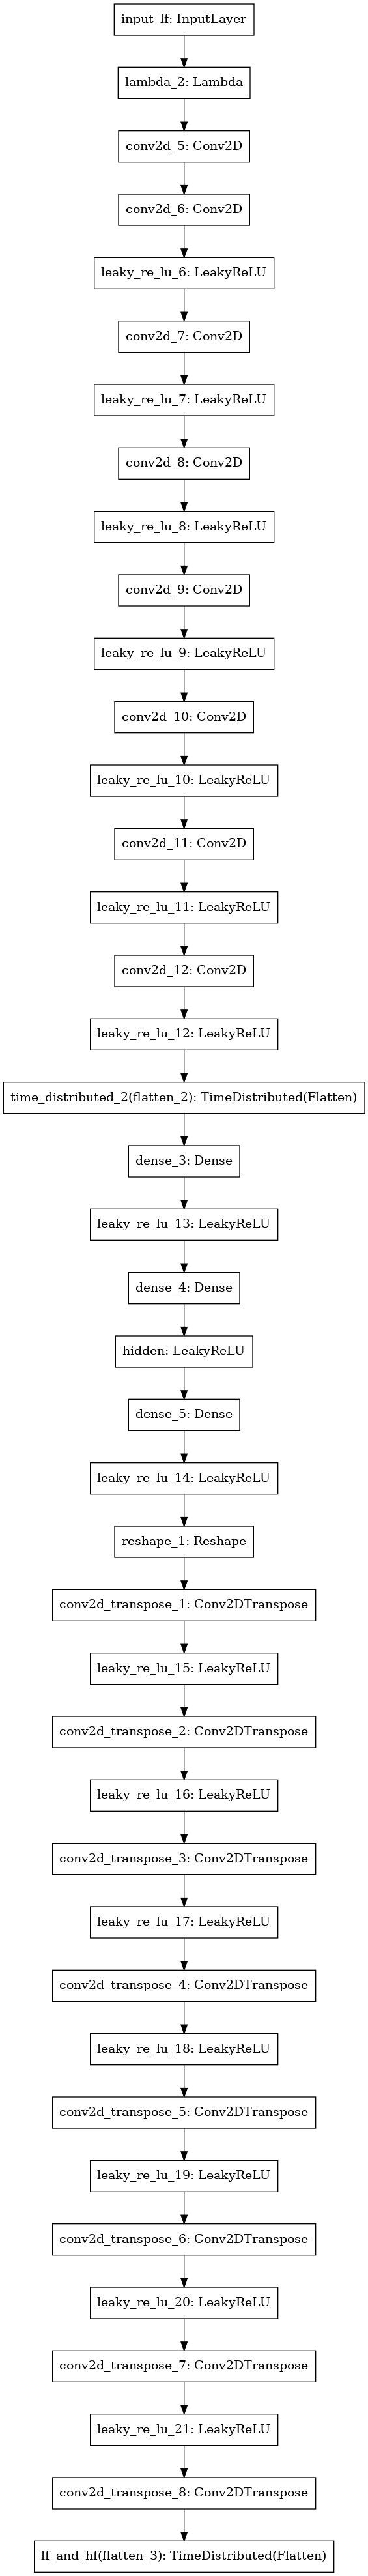

In [4]:
# baseline autoencoder - 4 encoding

def mk_model():
    input_lower = Input((None, 129), name="input_lf")
    layer = Lambda(lambda x: K.expand_dims(x))(input_lower)
    layer = Conv2D(16, kernel_size=(9,1), padding='same', activation='tanh')(layer)
    layer = LeakyReLU(0.01)(Conv2D(20, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.01)(Conv2D(24, kernel_size=(9,1), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.01)(Conv2D(28, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.01)(Conv2D(32, kernel_size=(9,1), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.01)(Conv2D(36, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.01)(Conv2D(42, kernel_size=(9,1), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.01)(Conv2D(48, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = TimeDistributed(Flatten())(layer)
    layer = LeakyReLU(0.01)(Dense(1024)(layer))
    hidden = layer = LeakyReLU(0.01, name='hidden')(Dense(96)(layer))
    layer = LeakyReLU(0.01)(Dense(2056)(layer))
    layer = Reshape((-1, 257,8))(layer)
    layer = LeakyReLU(0.01)(Deconv2D(48, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.01)(Deconv2D(42, kernel_size=(9,1), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.01)(Deconv2D(36, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.01)(Deconv2D(32, kernel_size=(9,1), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.01)(Deconv2D(28, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.01)(Deconv2D(24, kernel_size=(9,1), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.01)(Deconv2D(20, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = Deconv2D(1, kernel_size=(9,1), padding='same', activation='linear')(layer)
    lf_and_hf = TimeDistributed(Flatten(), name="lf_and_hf")(layer)
    mdl = Model(input_lower, lf_and_hf)
    mdl.summary()
    mdl.compile('adam', 'mse')
    return mdl

temp = tempfile.mktemp() + ".png"
mdl = mk_model()
model_callbacks.append(mk_model)
plot_model(mdl, to_file=temp)
Image(filename=temp)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_lf (InputLayer)        (None, None, 129)         0         
_________________________________________________________________
lambda_3 (Lambda)            (None, None, 129, 1)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, None, 129, 16)     160       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, None, 129, 20)     1620      
_________________________________________________________________
leaky_re_lu_22 (LeakyReLU)   (None, None, 129, 20)     0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, None, 129, 24)     4344      
_________________________________________________________________
leaky_re_lu_23 (LeakyReLU)   (None, None, 129, 24)     0         
__________

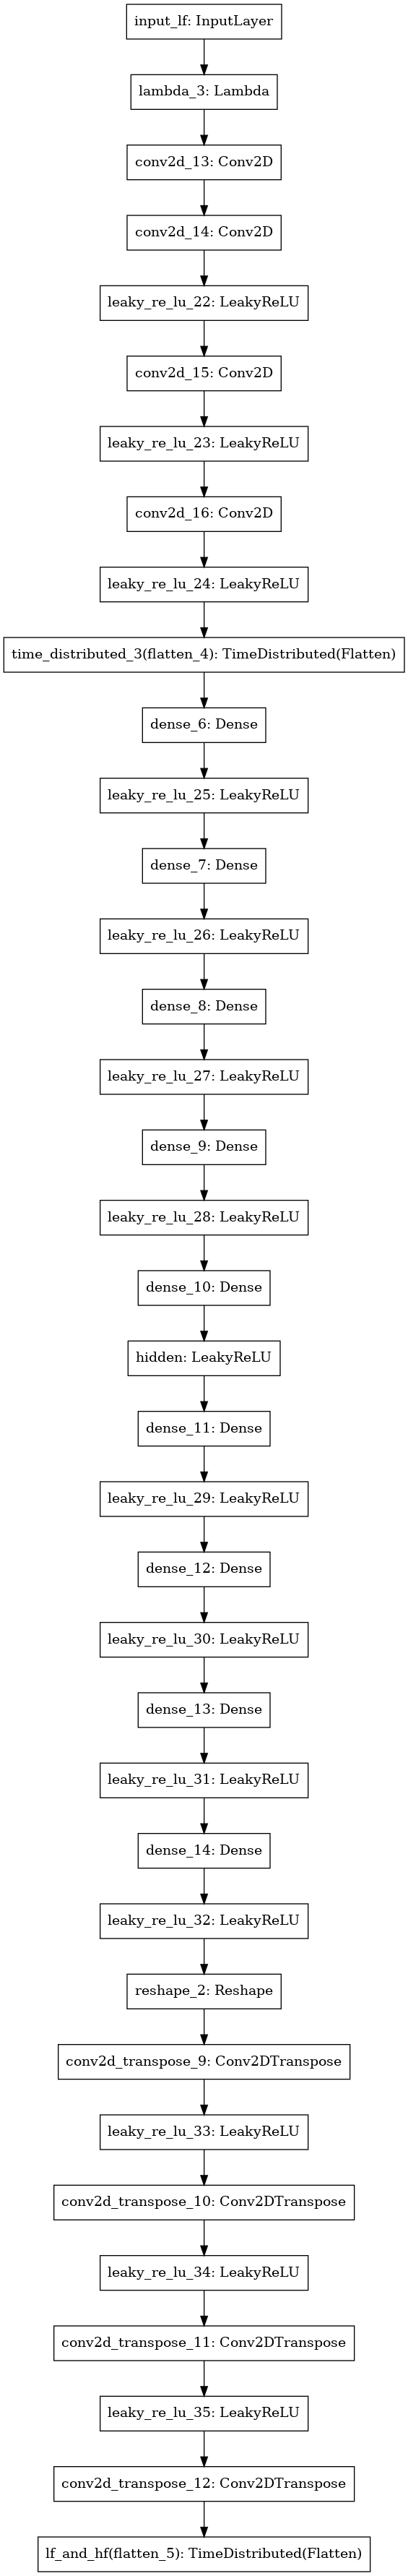

In [5]:
# baseline autoencoder - deeped mid representation - 4 layers

def mk_model():
    input_lower = Input((None, 129), name="input_lf")
    layer = Lambda(lambda x: K.expand_dims(x))(input_lower)
    layer = Conv2D(16, kernel_size=(9,1), padding='same', activation='tanh')(layer)
    layer = LeakyReLU(0.01)(Conv2D(20, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.01)(Conv2D(24, kernel_size=(9,1), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.01)(Conv2D(28, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = TimeDistributed(Flatten())(layer)
    layer = LeakyReLU(0.01)(Dense(1024)(layer))
    layer = LeakyReLU(0.01)(Dense(512)(layer))
    layer = LeakyReLU(0.01)(Dense(256)(layer))
    layer = LeakyReLU(0.01)(Dense(192)(layer))
    hidden = layer = LeakyReLU(0.01, name='hidden')(Dense(96)(layer))
    layer = LeakyReLU(0.01)(Dense(192)(layer))
    layer = LeakyReLU(0.01)(Dense(256)(layer))
    layer = LeakyReLU(0.01)(Dense(512)(layer))
    layer = LeakyReLU(0.01)(Dense(2056)(layer))
    layer = Reshape((-1, 257,8))(layer)
    layer = LeakyReLU(0.01)(Deconv2D(28, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.01)(Deconv2D(24, kernel_size=(9,1), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.01)(Deconv2D(20, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = Deconv2D(1, kernel_size=(9,1), padding='same', activation='linear')(layer)
    lf_and_hf = TimeDistributed(Flatten(), name="lf_and_hf")(layer)
    mdl = Model(input_lower, lf_and_hf)
    mdl.summary()
    mdl.compile('adam', 'mse')
    return mdl

temp = tempfile.mktemp() + ".png"
mdl = mk_model()
model_callbacks.append(mk_model)
plot_model(mdl, to_file=temp)
Image(filename=temp)

##### Data loading

In [ ]:
TRAIN = 9000
VALID = 80
TEST = 80

import numpy as np
import scipy.io.wavfile as sio
import gc

import tempfile
import subprocess

tempnam = tempfile.mktemp

log_fft_source = log_fft_target = phase = train = test = valid = experiment = None
gc.collect()

dataset = Dataset.from_folder("DAE-libri",
                              verbose = False,
                              dataset_pad = 8,
                              trim_lengths = 160000,
                              cache = "cache",
                              ram_cache_size = None,
                              filter=lambda x:x.endswith(".wav") and not x.endswith(".gsm.wav"))


log_fft_source = np.zeros([TRAIN + VALID + TEST, 1248, 129], np.float32)
log_fft_target = np.zeros([TRAIN + VALID + TEST, 1248, 257], np.float32)
phase = np.zeros([TEST, 1248, 129], np.float32)

for ix, file in enumerate(dataset.files[:TRAIN + VALID + TEST]):
    print(ix)
    data = sio.read(dataset.root + "/" + file)[1] # .astype(np.float32) to generate noise in the experiment...
    oldname = tempnam() + '.oldwav'
    sio.write(oldname, 16000, data)
    tmpname = tempnam() + '.amr-nb'
    newname = dataset.root + "/" + file + ".gsm.wav"
    subprocess.Popen(['sox', oldname, '-C', '0', '-r', '8000', tmpname]).communicate()
    subprocess.Popen(['sox', tmpname, '-r', '16000', "-e", "signed", '-b', '16',  newname]).communicate()
    list(map(os.remove, [oldname, tmpname]))


window = np.hamming(512)
for ix, file in enumerate(dataset.files[:TRAIN + VALID + TEST]):
    print(ix)
    r = sio.read(dataset.root + "/" + file)[1].astype(np.float32)
    r /= 2**15
    for time in range(1248):
        win = r[128 * time : 128 * time + 512]
        if len(win) != 512:
            break
        fft = np.fft.rfft(window * win) / 512
        log_fft_target[ix, time, :] = -np.log(np.abs(fft) ** 2 + 2e-12)
    r = sio.read(dataset.root + "/" + file + ".gsm.wav")[1].astype(np.float32)
    r /= 2**15
    for time in range(1248):
        win = r[128 * time : 128 * time + 512]
        if len(win) != 512:
            break
        fft = np.fft.rfft(window * win) / 512
        log_fft_source[ix, time, :] = -np.log(np.abs(fft) ** 2 + 2e-12)[:129]
        if ix >= TRAIN+VALID:
            phase[ix - TRAIN - VALID, time, :] = np.angle(fft)[:129]


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062


3502
3503
3504
3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701


5141
5142
5143
5144
5145
5146
5147
5148
5149
5150
5151
5152
5153
5154
5155
5156
5157
5158
5159
5160
5161
5162
5163
5164
5165
5166
5167
5168
5169
5170
5171
5172
5173
5174
5175
5176
5177
5178
5179
5180
5181
5182
5183
5184
5185
5186
5187
5188
5189
5190
5191
5192
5193
5194
5195
5196
5197
5198
5199
5200
5201
5202
5203
5204
5205
5206
5207
5208
5209
5210
5211
5212
5213
5214
5215
5216
5217
5218
5219
5220
5221
5222
5223
5224
5225
5226
5227
5228
5229
5230
5231
5232
5233
5234
5235
5236
5237
5238
5239
5240
5241
5242
5243
5244
5245
5246
5247
5248
5249
5250
5251
5252
5253
5254
5255
5256
5257
5258
5259
5260
5261
5262
5263
5264
5265
5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
5292
5293
5294
5295
5296
5297
5298
5299
5300
5301
5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325
5326
5327
5328
5329
5330
5331
5332
5333
5334
5335
5336
5337
5338
5339
5340


6782
6783
6784
6785
6786
6787
6788
6789
6790
6791
6792
6793
6794
6795
6796
6797
6798
6799
6800
6801
6802
6803
6804
6805
6806
6807
6808
6809
6810
6811
6812
6813
6814
6815
6816
6817
6818
6819
6820
6821
6822
6823
6824
6825
6826
6827
6828
6829
6830
6831
6832
6833
6834
6835
6836
6837
6838
6839
6840
6841
6842
6843
6844
6845
6846
6847
6848
6849
6850
6851
6852
6853
6854
6855
6856
6857
6858
6859
6860
6861
6862
6863
6864
6865
6866
6867
6868
6869
6870
6871
6872
6873
6874
6875
6876
6877
6878
6879
6880
6881
6882
6883
6884
6885
6886
6887
6888
6889
6890
6891
6892
6893
6894
6895
6896
6897
6898
6899
6900
6901
6902
6903
6904
6905
6906
6907
6908
6909
6910
6911
6912
6913
6914
6915
6916
6917
6918
6919
6920
6921
6922
6923
6924
6925
6926
6927
6928
6929
6930
6931
6932
6933
6934
6935
6936
6937
6938
6939
6940
6941
6942
6943
6944
6945
6946
6947
6948
6949
6950
6951
6952
6953
6954
6955
6956
6957
6958
6959
6960
6961
6962
6963
6964
6965
6966
6967
6968
6969
6970
6971
6972
6973
6974
6975
6976
6977
6978
6979
6980
6981


8421
8422
8423
8424
8425
8426
8427
8428
8429
8430
8431
8432
8433
8434
8435
8436
8437
8438
8439
8440
8441
8442
8443
8444
8445
8446
8447
8448
8449
8450
8451
8452
8453
8454
8455
8456
8457
8458
8459
8460
8461
8462
8463
8464
8465
8466
8467
8468
8469
8470
8471
8472
8473
8474
8475
8476
8477
8478
8479
8480
8481
8482
8483
8484
8485
8486
8487
8488
8489
8490
8491
8492
8493
8494
8495
8496
8497
8498
8499
8500
8501
8502
8503
8504
8505
8506
8507
8508
8509
8510
8511
8512
8513
8514
8515
8516
8517
8518
8519
8520
8521
8522
8523
8524
8525
8526
8527
8528
8529
8530
8531
8532
8533
8534
8535
8536
8537
8538
8539
8540
8541
8542
8543
8544
8545
8546
8547
8548
8549
8550
8551
8552
8553
8554
8555
8556
8557
8558
8559
8560
8561
8562
8563
8564
8565
8566
8567
8568
8569
8570
8571
8572
8573
8574
8575
8576
8577
8578
8579
8580
8581
8582
8583
8584
8585
8586
8587
8588
8589
8590
8591
8592
8593
8594
8595
8596
8597
8598
8599
8600
8601
8602
8603
8604
8605
8606
8607
8608
8609
8610
8611
8612
8613
8614
8615
8616
8617
8618
8619
8620


In [7]:
MEAN = 0 # min([log_fft_source.min(), log_fft_target.min()])
mean = log_fft_source.mean()
#log_fft_source -= MEAN
#log_fft_target -= MEAN
STD = []
for i in range(log_fft_source.shape[0]):
    rec = (log_fft_source[i] - mean) ** 2
    STD.append(rec.mean())
STD = np.sqrt(np.array(STD).mean())
log_fft_source /= STD
log_fft_target /= STD
print(log_fft_source.min(), log_fft_source.max())
print(STD)

0.0 4.252722


In [8]:
train = log_fft_source[:TRAIN,:,:129], log_fft_target[:TRAIN]
valid = log_fft_source[TRAIN:TRAIN+VALID,:,:129], log_fft_target[TRAIN:TRAIN+VALID]
test = log_fft_source[TRAIN+VALID:TRAIN+VALID+TEST,:,:129], log_fft_target[TRAIN+VALID:TRAIN+VALID+TEST]

##### Training

In [9]:
"""
To experiment add:
    printing experiment name
    saving progress to make it probeable
    callbacks of convergence
"""

class StopOnConvergence(Callback):
    """Callback that terminates training when a NaN loss is encountered.
    """

    def __init__(self, max_repetitions=10):
        super().__init__()
        self.max_repetitions = max_repetitions
    
    def on_train_begin(self, logs=None):
        self.repetitions = 0
        self.last_loss = np.inf
    
    def on_epoch_end(self, batch, logs=None):
        logs = logs or {}
        loss = logs.get('val_loss')
        if loss is not None:
            if loss > self.last_loss:
                self.repetitions += 1
            else:
                self.last_loss = loss
                self.repetitions = 0
            if self.repetitions > self.max_repetitions:
                self.model.stop_training = True


experiment_names = []

# assert that all models have a layer with hidden representation
for mk_model in model_callbacks:
    mdl = mk_model()
    assert len([x.name for x in mdl.layers if x.name == "hidden"]) == 1

for mk_model in model_callbacks:
    experiment = SingleExperiment(mk_model, train = train, valid = valid, test = test, run_parameters={"batch_size": 8})
    experiment.add_schedule(Schedule([0.001, 0.0001, 0.00001], [100, 100, 100], lambda rate: keras.optimizers.Adam(rate, clipvalue = 1.)))
    experiment.add_measure(MSE(), name='mse')
    experiment.add_callback(StopOnConvergence(4))
    experiment.run()
    experiment_names.append(experiment.name)
    experiment.report()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_lf (InputLayer)        (None, None, 129)         0         
_________________________________________________________________
lambda_4 (Lambda)            (None, None, 129, 1)      0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, None, 129, 16)     160       
_________________________________________________________________
leaky_re_lu_36 (LeakyReLU)   (None, None, 129, 16)     0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, None, 129, 20)     1620      
_________________________________________________________________
leaky_re_lu_37 (LeakyReLU)   (None, None, 129, 20)     0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, None, 129, 24)     4344      
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_lf (InputLayer)        (None, None, 129)         0         
_________________________________________________________________
lambda_6 (Lambda)            (None, None, 129, 1)      0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, None, 129, 16)     160       
_________________________________________________________________
conv2d_30 (Conv2D)           (None, None, 129, 20)     1620      
_________________________________________________________________
leaky_re_lu_57 (LeakyReLU)   (None, None, 129, 20)     0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, None, 129, 24)     4344      
_________________________________________________________________
leaky_re_lu_58 (LeakyReLU)   (None, None, 129, 24)     0         
__________

Train on 9000 samples, validate on 80 samples
Epoch 1/100
9000/9000 [==============================] - 987s 110ms/step - loss: 0.1830 - val_loss: 0.0975
Epoch 2/100
9000/9000 [==============================] - 985s 109ms/step - loss: 0.0959 - val_loss: 0.0997
Epoch 3/100
9000/9000 [==============================] - 987s 110ms/step - loss: 0.0888 - val_loss: 0.0847
Epoch 4/100
9000/9000 [==============================] - 985s 109ms/step - loss: 0.0816 - val_loss: 0.0806
Epoch 5/100
9000/9000 [==============================] - 981s 109ms/step - loss: 0.1267 - val_loss: 0.0867
Epoch 6/100
9000/9000 [==============================] - 981s 109ms/step - loss: 0.0856 - val_loss: 0.0817
Epoch 7/100
9000/9000 [==============================] - 982s 109ms/step - loss: 0.0804 - val_loss: 0.0769
Epoch 8/100
9000/9000 [==============================] - 982s 109ms/step - loss: 0.0766 - val_loss: 0.0846
Epoch 9/100
9000/9000 [==============================] - 983s 109ms/step - loss: 0.0740 - val_loss

Train on 9000 samples, validate on 80 samples
Epoch 1/100
9000/9000 [==============================] - 352s 39ms/step - loss: 0.1946 - val_loss: 0.1300
Epoch 2/100
9000/9000 [==============================] - 349s 39ms/step - loss: 0.1044 - val_loss: 0.0917
Epoch 3/100
9000/9000 [==============================] - 349s 39ms/step - loss: 0.0941 - val_loss: 0.0932
Epoch 4/100
9000/9000 [==============================] - 349s 39ms/step - loss: 0.0879 - val_loss: 0.0900
Epoch 5/100
9000/9000 [==============================] - 349s 39ms/step - loss: 0.0866 - val_loss: 0.0832
Epoch 6/100
9000/9000 [==============================] - 349s 39ms/step - loss: 0.0820 - val_loss: 0.0804
Epoch 7/100
9000/9000 [==============================] - 349s 39ms/step - loss: 0.0784 - val_loss: 0.0834
Epoch 8/100
9000/9000 [==============================] - 349s 39ms/step - loss: 0.0772 - val_loss: 0.0867
Epoch 9/100
9000/9000 [==============================] - 349s 39ms/step - loss: 0.0759 - val_loss: 0.0745


In [10]:
with open("/tmp/test_data.bin", "wb") as f:
    pickle.dump((test, phase), f)
    
with open("/tmp/data_norm.bin", "wb") as f:
    pickle.dump((MEAN, STD), f)

In [12]:
experiment_names

['./runs/1539778769.198681',
 './runs/1539786707.1141675',
 './runs/1539826130.0951104']

### After reset

##### Load models and data

In [2]:
# import from first cell after restarting kernel

experiment_names = ['./runs/1539778769.198681',
 './runs/1539786707.1141675',
 './runs/1539826130.0951104']

In [6]:
with open("/tmp/test_data.bin", "rb") as f:
    test, old_phase = pickle.load(f)
    
with open("/tmp/data_norm.bin", "rb") as f:
    MEAN, STD = pickle.load(f)

['results.pkl', 'model.h5', 'history.pkl']
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_lf (InputLayer)        (None, None, 129)         0         
_________________________________________________________________
lambda_7 (Lambda)            (None, None, 129, 1)      0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, None, 129, 16)     160       
_________________________________________________________________
leaky_re_lu_71 (LeakyReLU)   (None, None, 129, 16)     0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, None, 129, 20)     1620      
_________________________________________________________________
leaky_re_lu_72 (LeakyReLU)   (None, None, 129, 20)     0         
_________________________________________________________________
conv2d_35 (Conv2D)           (Non

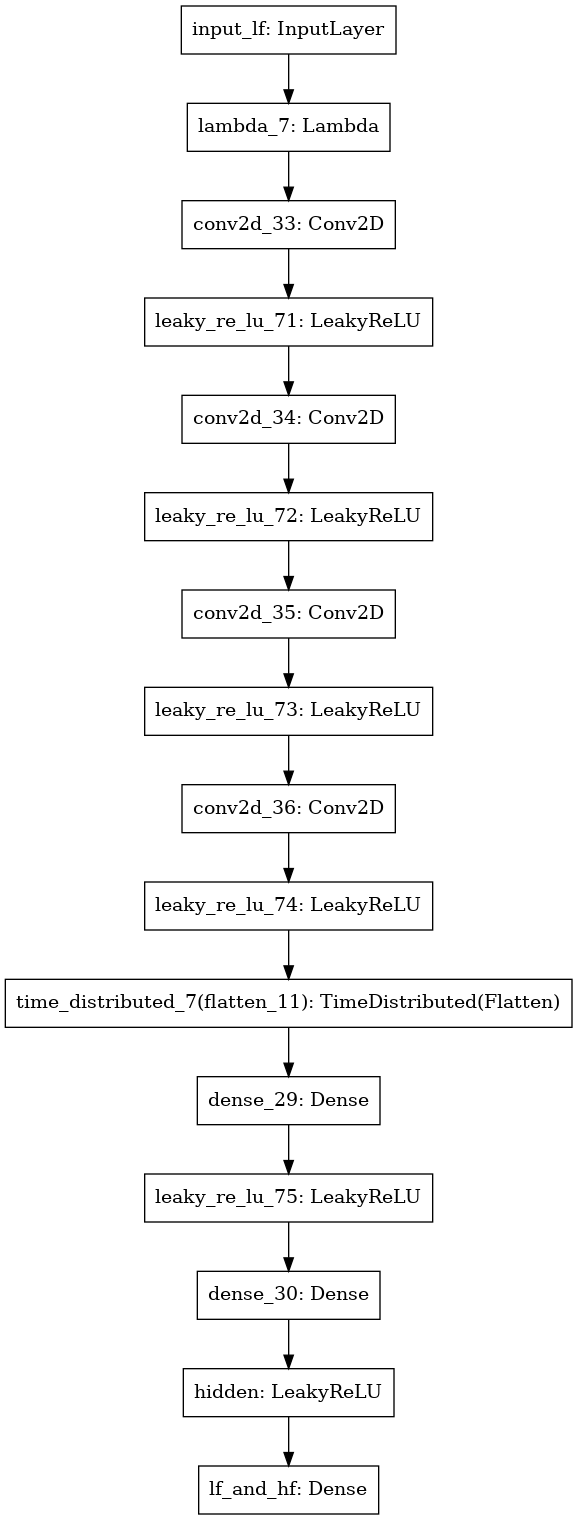

['results.pkl', 'model.h5', 'history.pkl']
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_lf (InputLayer)        (None, None, 129)         0         
_________________________________________________________________
lambda_8 (Lambda)            (None, None, 129, 1)      0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, None, 129, 16)     160       
_________________________________________________________________
conv2d_38 (Conv2D)           (None, None, 129, 20)     1620      
_________________________________________________________________
leaky_re_lu_76 (LeakyReLU)   (None, None, 129, 20)     0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, None, 129, 24)     4344      
_________________________________________________________________
leaky_re_lu_77 (LeakyReLU)   (Non

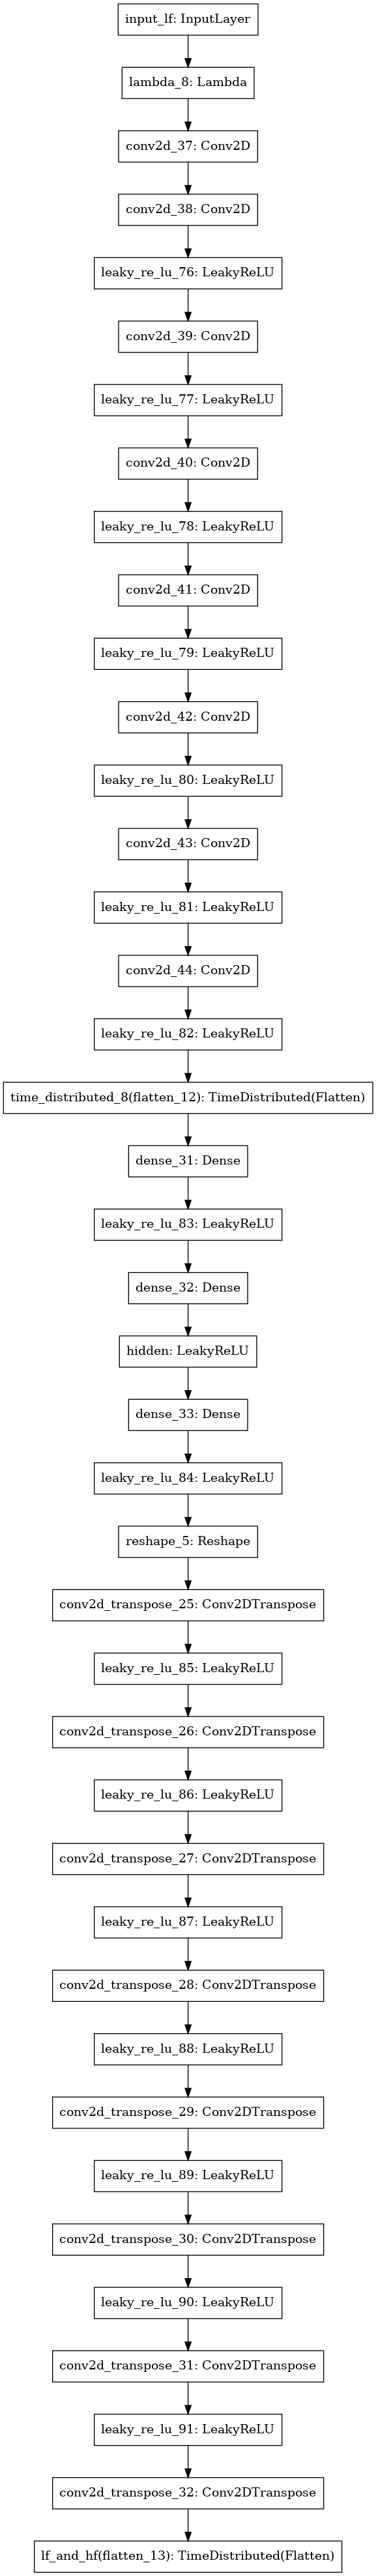

['results.pkl', 'model.h5', 'history.pkl']
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_lf (InputLayer)        (None, None, 129)         0         
_________________________________________________________________
lambda_9 (Lambda)            (None, None, 129, 1)      0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, None, 129, 16)     160       
_________________________________________________________________
conv2d_46 (Conv2D)           (None, None, 129, 20)     1620      
_________________________________________________________________
leaky_re_lu_92 (LeakyReLU)   (None, None, 129, 20)     0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, None, 129, 24)     4344      
_________________________________________________________________
leaky_re_lu_93 (LeakyReLU)   (Non

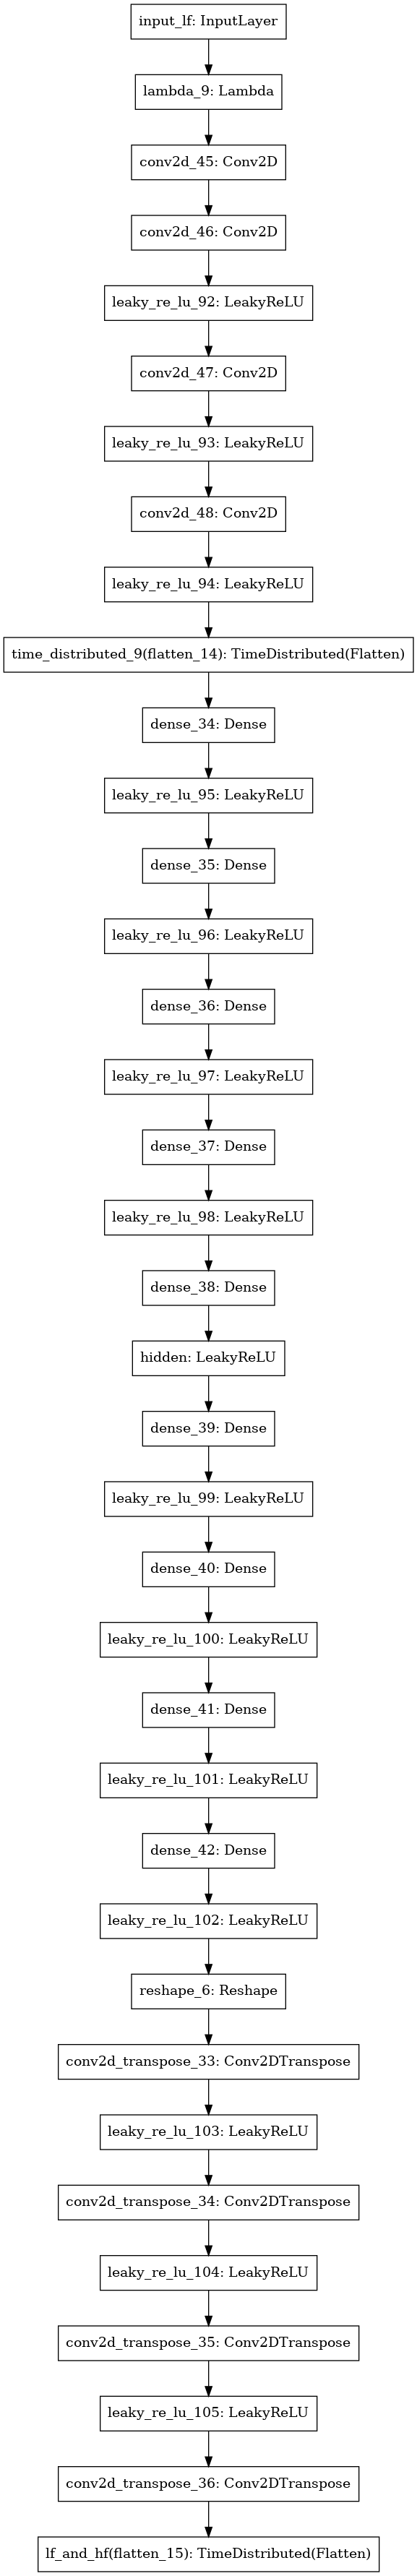

In [4]:
models = []

for model in experiment_names:
    mdl = Estimator.only_model(model)
    mdl.summary()
    print("-----\n" + model)
    models.append(mdl)
    try:
        temp = tempfile.mktemp() + ".png"
        plot_model(mdl, to_file=temp)
        display(Image(filename=temp))
    except:
        pass

In [5]:
# visualisation

image, gt = test

plt.figure(figsize=(15,10))
plt.title("Baseline image")
plt.imshow(np.rot90(gt[0, :, :]) * STD + MEAN, aspect='auto')
plt.colorbar()
plt.show()

for name, mdl in zip(experiment_names, models):
    prediction = mdl.predict(image[:1]) * STD + MEAN
    plt.figure(figsize=(15,10))
    plt.title("Experiment: " + name)
    plt.imshow(np.rot90(prediction[0, :, :]), aspect='auto')
    plt.colorbar()
    plt.show()

ValueError: too many values to unpack (expected 2)

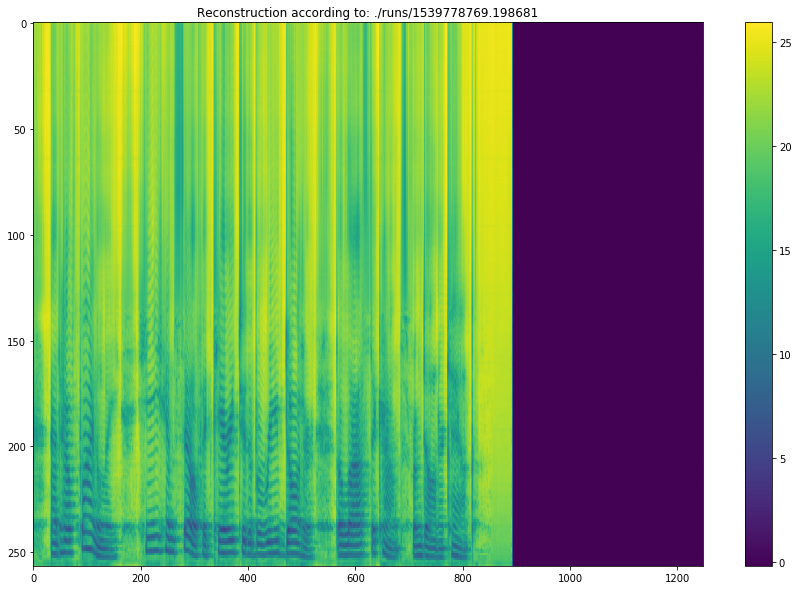

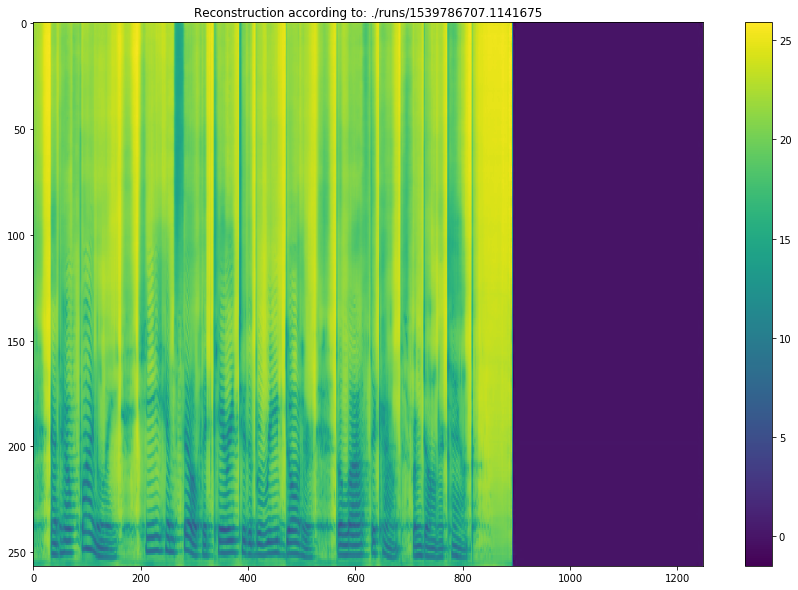

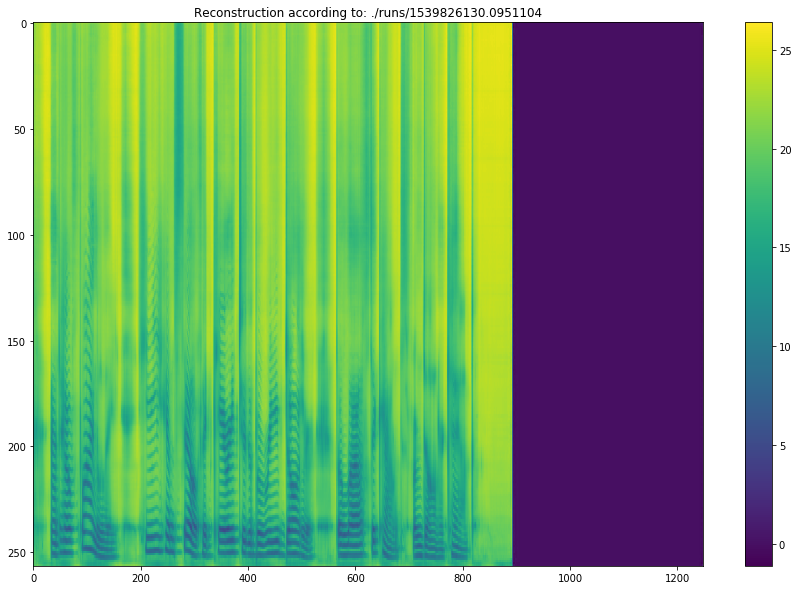

In [7]:
# hidden representation of each model - verify variability

image, gt = test

for name, mdl in zip(experiment_names, models):
    model = (mdl.input, [x.output for x in mdl.layers if x.name == "hidden"][0])
    prediction = mdl.predict(image[:1]) * STD + MEAN
    plt.figure(figsize=(15,10))
    plt.title("Reconstruction according to: " + name)
    plt.imshow(np.rot90(prediction[0, :, :]), aspect='auto')
    plt.colorbar()
    plt.show()

Groundtruth signal


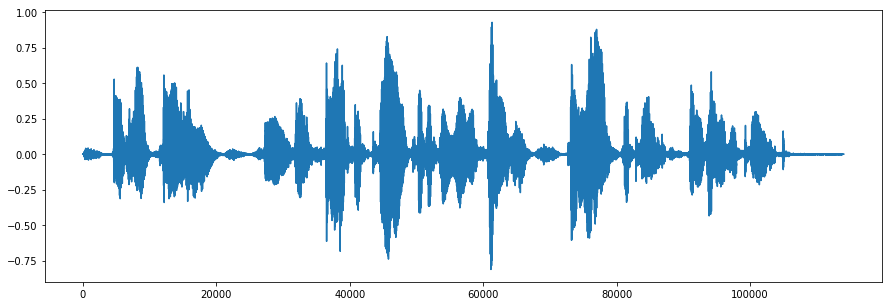

Input signal


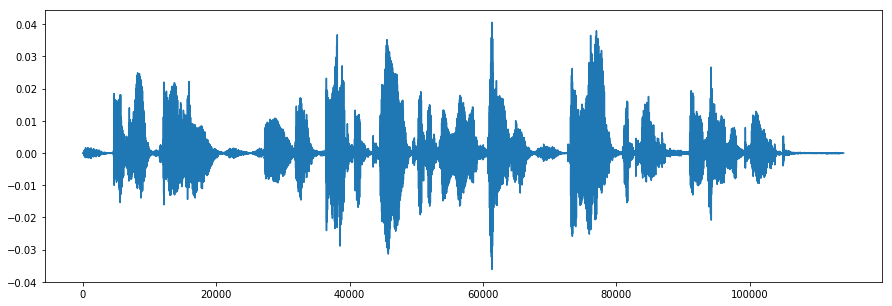

Prediction of ./runs/1539778769.198681


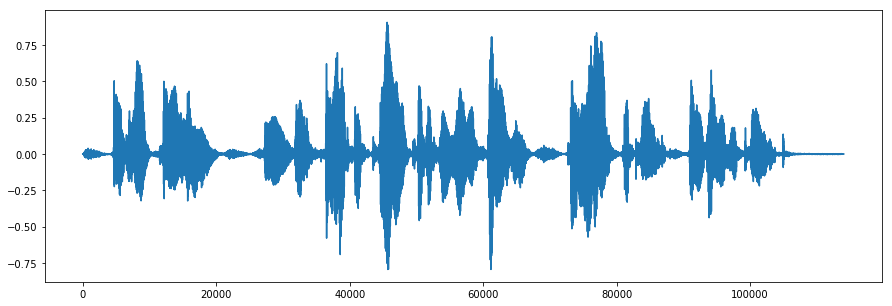

Prediction of ./runs/1539786707.1141675


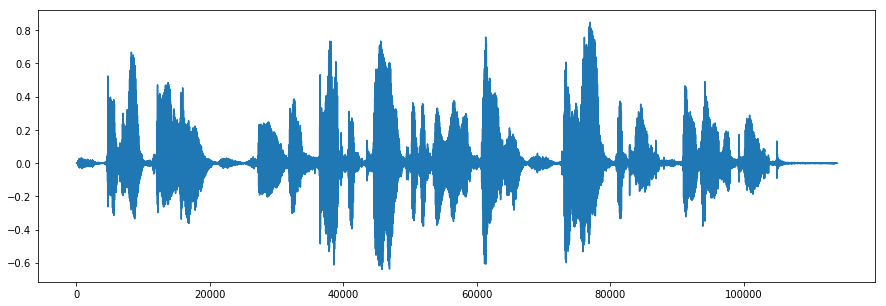

Prediction of ./runs/1539826130.0951104


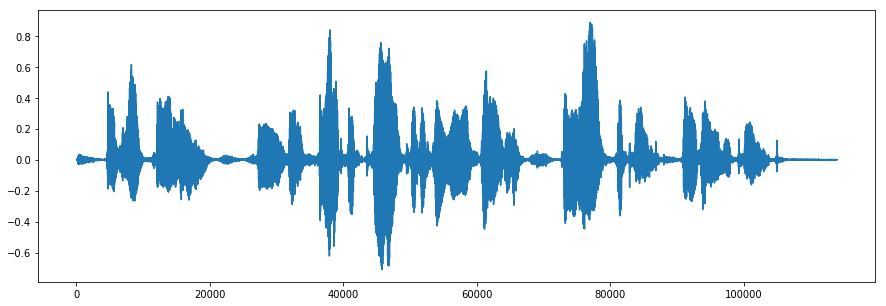

In [10]:
# predicted spectrograms

phase = np.zeros(gt.shape)
phase[:,:,:129] = old_phase
phase[:, :, 129:] = old_phase[:, :, :0:-1]

window = np.hamming(512)

print("Groundtruth signal")
sound = gt[0] * STD + MEAN
spec = (np.sqrt(np.exp(-sound)) * 512) * np.exp(phase[0, :, :] * 1j)

length = len(np.where((gt[0, :, :] != 0).sum(1))[0]) - 4
sound = np.zeros(length * 128 + 512 - 128)

for i in range(length):
    frame = np.fft.irfft(spec[i,:])
    sound[128 * i : 128 * i + 512] += window * frame
plt.figure(figsize=(15,5))
plt.plot(sound)
plt.show()
display(Audio(sound, rate=16000))

print("Input signal")
sound = image[0]  * STD + MEAN
spec = np.zeros(gt[0].shape, np.complex)
spec[:,:129] = (np.sqrt(np.exp(-(sound)) * 512) * np.exp(phase[0, :, :129] * 1j))
sound = np.zeros(length * 128 + 512 - 128)
for i in range(length):
    frame = np.fft.irfft(spec[i,:])
    sound[128 * i : 128 * i + 512] += window * frame
plt.figure(figsize=(15,5))
plt.plot(sound)
plt.show()
display(Audio(sound, rate=16000))


for name, mdl in zip(experiment_names, models):
    print("Prediction of " + name)
    spec = mdl.predict(image[:1])[0]  * STD + MEAN
    sound = np.zeros(length * 128 + 512 - 128)
    spec = (np.sqrt(np.exp(-spec)) * 512) * np.exp(phase[0, :, :] * 1j)
    for i in range(length):
        frame = np.fft.irfft(spec[i,:])
        sound[128 * i : 128 * i + 512] += window * frame
    plt.figure(figsize=(15,5))
    plt.plot(sound)
    plt.show()
    display(Audio(sound, rate=16000))


##### Metrics

In [11]:
import subprocess
import re

def pesq(gt, pred, phase):
    spec = (np.sqrt(np.exp(-gt)) * 512) * np.exp(phase * 1j)
    sound = np.zeros(spec.shape[0] * 128 + 512 - 128)
    for i in range(spec.shape[0]):
        frame = np.fft.irfft(spec[i,:])
        sound[128 * i : 128 * i + 512] += frame
    spec = (np.sqrt(np.exp(-pred)) * 512) * np.exp(phase * 1j)
    sound2 = np.zeros(spec.shape[0] * 128 + 512 - 128)
    for i in range(spec.shape[0]):
        frame = np.fft.irfft(spec[i,:])
        sound2[128 * i : 128 * i + 512] += frame
    fname_gt = tempfile.mktemp() + ".wav"
    fname_pred = tempfile.mktemp() + ".wav"
    # print(sound.shape, sound2.shape)
    sio.write(fname_gt, 16000, (2**15 * sound).astype(np.int16))
    sio.write(fname_pred, 16000, (2**15 * sound2).astype(np.int16))
    ot,e = subprocess.Popen(["PESQ", "+wb", "+16000", fname_gt, fname_pred], stdout = subprocess.PIPE, stderr = subprocess.PIPE).communicate()
    os.remove(fname_gt)
    os.remove(fname_pred)
    # print(ot)
    o = ot.decode("utf-8").split('\n')[-2]
    # print(o, len(o))
    # if not len(o):
    #     print(ot.decode("utf-8"))
    value = re.findall("= \d\.\d+", o)[0]
    # print(value)
    return float(value[2:])

inp, gtruth = test
n_phase = phase[:]
preds = gtruth * 0
preds[:, :, :129] = STD * inp + MEAN
quality = []
print(gtruth.shape, preds.shape, n_phase.shape)
gtruth = STD * gtruth + MEAN
for i in range(gtruth.shape[0]):
    try:
        quality.append(pesq(gtruth[i], preds[i], n_phase[i]))
    except IndexError:
        print("Failed getting PESQ value for recording {}".format(i))
print("No processing PESQ:", np.array(quality).mean())

quality_arrays = []

for name, mdl in zip(experiment_names, models):
    preds = mdl.predict(inp)
    preds[:, :, :129] = gt[:, :, :129]
    preds = STD * preds + MEAN
    quality = []
    for i in range(gtruth.shape[0]):
        try:
            quality.append(pesq(gtruth[i], preds[i], n_phase[i]))
        except IndexError:
            print("Failed getting PESQ value for recording {}".format(i))
    print("Predicted by model {}:".format(name), np.array(quality).mean(), "+-", np.array(quality).std())
    quality_arrays.append(np.array(quality))

(80, 1248, 257) (80, 1248, 257) (80, 1248, 257)
No processing PESQ: 1.1094000000000002
Predicted by model ./runs/1539778769.198681: 3.6594499999999996 +- 0.6073385773191096
Predicted by model ./runs/1539786707.1141675: 3.7189375 +- 0.6803241018762675
Predicted by model ./runs/1539826130.0951104: 3.7231249999999996 +- 0.6462631695950188


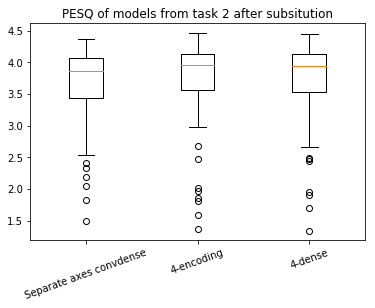

In [13]:
plot_model_names = ["Separate axes convdense", "4-encoding", "4-dense"]
plt.boxplot(quality_arrays, labels=plot_model_names)
plt.xticks(rotation=20)
plt.title("PESQ of models from task 2 after subsitution")
plt.show()

[12, 34, 34]


Text(0.5,1,'Percentage of preference across models, according to PESQ, task 2')

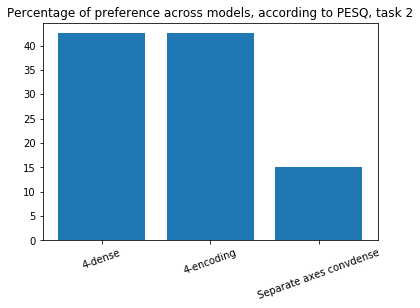

In [14]:
# old loaded data (seemingly ok): [7, 1, 7, 13, 15, 0, 7, 21, 9]

preferences = np.stack(quality_arrays).argmax(0)
from collections import Counter

c = Counter(preferences)
prefs = [c[x] for x in range(len(models))]
print(prefs)
plt.bar(plot_model_names, np.array(prefs) / 80 * 100)
plt.xticks(rotation=20)
plt.title("Percentage of preference across models, according to PESQ, task 2")

In [15]:
import subprocess
import re

def pesq(gt, pred, phase):
    spec = (np.sqrt(np.exp(-gt)) * 512) * np.exp(phase * 1j)
    sound = np.zeros(spec.shape[0] * 128 + 512 - 128)
    for i in range(spec.shape[0]):
        frame = np.fft.irfft(spec[i,:])
        sound[128 * i : 128 * i + 512] += frame
    spec = (np.sqrt(np.exp(-pred)) * 512) * np.exp(phase * 1j)
    sound2 = np.zeros(spec.shape[0] * 128 + 512 - 128)
    for i in range(spec.shape[0]):
        frame = np.fft.irfft(spec[i,:])
        sound2[128 * i : 128 * i + 512] += frame
    fname_gt = tempfile.mktemp() + ".wav"
    fname_pred = tempfile.mktemp() + ".wav"
    # print(sound.shape, sound2.shape)
    sio.write(fname_gt, 16000, (2**15 * sound).astype(np.int16))
    sio.write(fname_pred, 16000, (2**15 * sound2).astype(np.int16))
    ot,e = subprocess.Popen(["PESQ", "+wb", "+16000", fname_gt, fname_pred], stdout = subprocess.PIPE, stderr = subprocess.PIPE).communicate()
    os.remove(fname_gt)
    os.remove(fname_pred)
    # print(ot)
    o = ot.decode("utf-8").split('\n')[-2]
    # print(o, len(o))
    # if not len(o):
    #     print(ot.decode("utf-8"))
    value = re.findall("= \d\.\d+", o)[0]
    # print(value)
    return float(value[2:])

inp, gtruth = test
n_phase = phase[:]
preds = gtruth * 0
preds[:, :, :129] = STD * inp + MEAN
quality = []
print(gtruth.shape, preds.shape, n_phase.shape)
gtruth = STD * gtruth + MEAN
for i in range(gtruth.shape[0]):
    try:
        quality.append(pesq(gtruth[i], preds[i], n_phase[i]))
    except IndexError:
        print("Failed getting PESQ value for recording {}".format(i))
print("No processing PESQ:", np.array(quality).mean())

quality_arrays = []

for name, mdl in zip(experiment_names, models):
    preds = mdl.predict(inp)
    preds = STD * preds + MEAN
    quality = []
    for i in range(gtruth.shape[0]):
        try:
            quality.append(pesq(gtruth[i], preds[i], n_phase[i]))
        except IndexError:
            print("Failed getting PESQ value for recording {}".format(i))
    print("Predicted by model {}:".format(name), np.array(quality).mean(), "+-", np.array(quality).std())
    quality_arrays.append(np.array(quality))

(80, 1248, 257) (80, 1248, 257) (80, 1248, 257)
No processing PESQ: 1.1094000000000002
Predicted by model ./runs/1539778769.198681: 2.8959625000000004 +- 0.5573500570501002
Predicted by model ./runs/1539786707.1141675: 2.8728375 +- 0.6914572735127963
Predicted by model ./runs/1539826130.0951104: 2.3527875 +- 0.5790949553775702


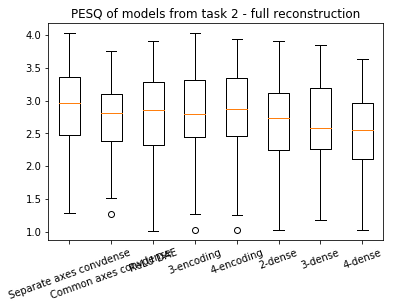

In [40]:
plot_model_names = ["Separate axes convdense", "Common axes convdense", "ReLU DAE", "3-encoding", "4-encoding", "2-dense", "3-dense", "4-dense"]
plt.boxplot(quality_arrays, labels=plot_model_names)
plt.xticks(rotation=20)
plt.title("PESQ of models from task 2 - full reconstruction")
plt.show()

[22, 9, 15, 19, 13, 1, 1, 0]


Text(0.5,1,'Percentage of preference across models, according to PESQ, task 2 - full reconstruction')

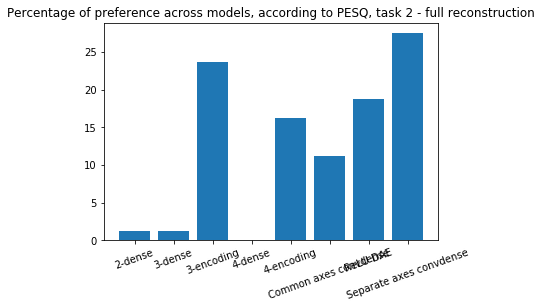

In [41]:
# old loaded data (seemingly ok): [7, 1, 7, 13, 15, 0, 7, 21, 9]

preferences = np.stack(quality_arrays).argmax(0)
from collections import Counter

c = Counter(preferences)
prefs = [c[x] for x in range(len(models))]
print(prefs)
plt.bar(plot_model_names, np.array(prefs) / 80 * 100)
plt.xticks(rotation=20)
plt.title("Percentage of preference across models, according to PESQ, task 2 - full reconstruction")

In [17]:
# log power MSE

inp, gtruth = test
preds = mdl.predict(inp)  * STD + MEAN
gtruth = gtruth * STD + MEAN

preds = gtruth * 0
preds[:, :, :129] = inp
logmse=[]
for i in range(gtruth.shape[0]):
    length = len(np.where((gtruth[i, :, :] != 0).sum(1))[0])
    logmse.append(((preds[i, :length, :] - gtruth[i, :length, :]) ** 2).mean())
print("Baseline log-power MSE:", np.array(logmse).mean())

for name, mdl in zip(experiment_names, models):
    logmse=[]
    preds = mdl.predict(inp) * STD + MEAN
    for i in range(gtruth.shape[0]):
        length = len(np.where((gtruth[i, :, :] != 0).sum(1))[0])
        logmse.append(((preds[i, :length, :] - gtruth[i, :length, :]) ** 2).mean())
    print("Log-power MSE of {}:".format(name), np.array(logmse).mean(), "+-", np.array(logmse).std())



Baseline log-power MSE: 364.73495
Log-power MSE of ./runs/1539778769.198681: 2.5782313 +- 0.41621566
Log-power MSE of ./runs/1539786707.1141675: 2.5675159 +- 0.42451563
Log-power MSE of ./runs/1539826130.0951104: 2.6946173 +- 0.41782883


In [18]:
# log-spectral distance


inp, gtruth = test
gtruth = STD * gtruth + MEAN
preds = gtruth * 0
preds[:, :, :129] = STD * inp + MEAN
lsd = []
innermost = (10 * ((-preds) - (-gtruth)) / np.log(10)) ** 2
for i in range(gtruth.shape[0]):
    inner = innermost[i, :, :]
    length = len(np.where((gtruth[i, :, :] != 0).sum(1))[0])
    inner = inner[:length]
    sublsd = []
    for t in range(length):
        step = 2 / 513
        frame = inner[t]
        integral = frame.sum()
        sublsd.append(np.sqrt(step * integral))
    lsd.append(np.array(sublsd).mean())
print("Log-spectral distance of baseline:", np.array(lsd).mean())

for name, mdl in zip(experiment_names, models):
    preds = STD * mdl.predict(inp) + MEAN
    lsd = []
    innermost = (10 * ((-preds) - (-gtruth)) / np.log(10)) ** 2
    for i in range(gtruth.shape[0]):
        inner = innermost[i, :, :]
        length = len(np.where((gtruth[i, :, :] != 0).sum(1))[0])
        inner = inner[:length]
        sublsd = []
        for t in range(length):
            step = 2 / 513
            frame = inner[t]
            integral = frame.sum()
            sublsd.append(np.sqrt(step * integral))
        lsd.append(np.array(sublsd).mean())
    print("Log-spectral distance of {}:".format(name), np.array(lsd).mean(), "+-", np.array(lsd).std())

Log-spectral distance of baseline: 66.6270237693505
Log-spectral distance of ./runs/1539778769.198681: 6.642401832464114 +- 0.5206423452373734
Log-spectral distance of ./runs/1539786707.1141675: 6.625339572772044 +- 0.5058448864759031
Log-spectral distance of ./runs/1539826130.0951104: 6.811850801773218 +- 0.5131995030924646


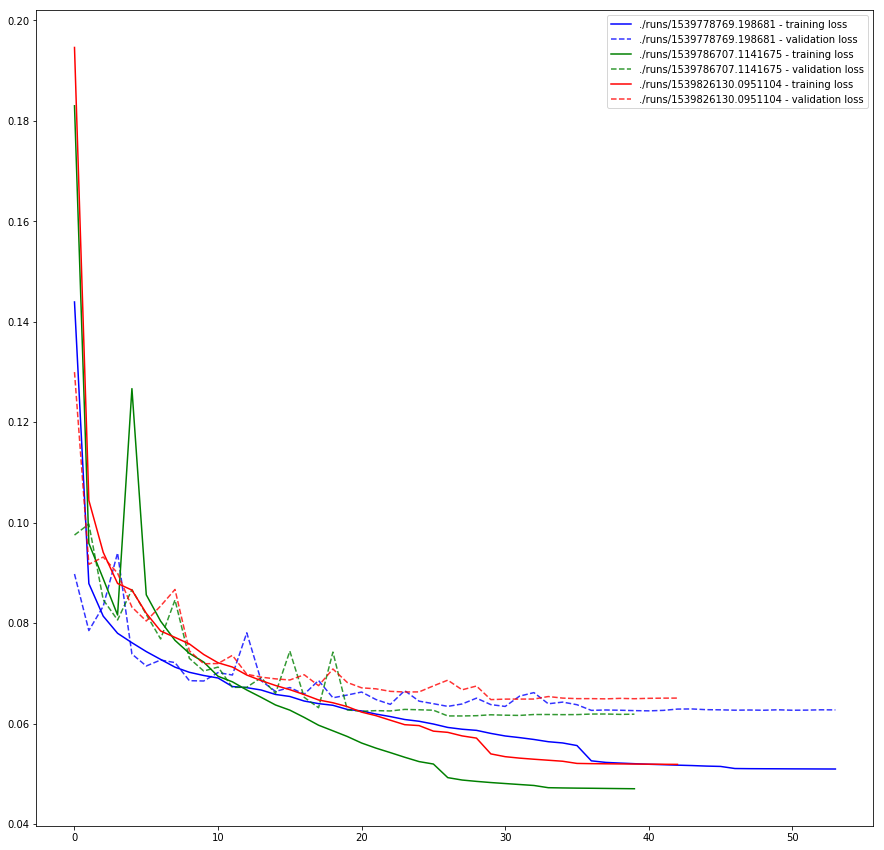

In [19]:
# Losses during training

legend_labels = []
colors = "bgrcmykbgrcmyk"
train_linestyles = ["-"] * 7 + ["-."] * 7
val_linestyles = ["--"] * 7 + ["dotted"] * 7
plt.figure(figsize=(15,15))
for color, tl, vl, model in zip(colors, train_linestyles, val_linestyles, experiment_names):
    with open(model + "/history.pkl", "rb") as f:
        hist = pickle.load(f)
    loss = hist['loss']
    val_loss = hist['val_loss']
    plt.plot(loss, linestyle=tl, color=color)
    plt.plot(val_loss, linestyle=vl, color=color, alpha=0.8)
    legend_labels.append(model + " - training loss")
    legend_labels.append(model + " - validation loss")
plt.legend(legend_labels)
plt.show()